In [1]:
# Import the usual libraries
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
#import matplotlib.patches as mpatches

# Enable inline plotting
%matplotlib inline

#from IPython.display import display, Latex, clear_output

In [2]:
import os
import pynrc
from pynrc import nrc_utils
from pynrc import robust

[   webbpsf:INFO] NIRCam aperture name updated to NRCA1_FULL


In [3]:
from pynrc.detops import create_detops
from pynrc.reduce.ref_pixels import reffix_hxrg
from pynrc.nrc_utils import jl_poly_fit, jl_poly
from pynrc.simul.ngNRC import get_ipc_kernel, ipc_deconvolve, ppc_deconvolve

In [4]:
from astropy.io import fits
from scipy import ndimage

In [5]:
basedir = '/Users/Jarron/NIRCam/darks_old/CV3/FITS/'

scaid = 485
indir = os.path.join(basedir, str(scaid)) + '/'

# Get file names within directory
allfits = [file for file in os.listdir(indir) if file.endswith('.fits')]
allfits = np.sort(allfits)

In [6]:
# Get header information and create a NIRCam detector timing instance
hdr = fits.getheader(indir+allfits[0])
det = create_detops(hdr)

nchan = det.nout
nx = det.xpix
ny = det.ypix
nz = det.multiaccum.ngroup
chsize = det.chsize

# Time array
tarr = np.arange(1, nz+1) * det.time_group

[     pynrc:INFO] Initializing SCA 485/A5


# Superbias and Superdark

In [7]:
# Create a superbias
bias_all = []
for f in allfits:
    print(f)
    hdul = fits.open(indir + f)
    data = hdul[0].data.astype(np.float)
    hdul.close()

    data = reffix_hxrg(data, nchans=nchan, altcol=True, in_place=True, 
                       fixcol=True, avg_type='pixel', savgol=True, perint=True)
    bias, slope = jl_poly_fit(tarr, data)
    del data
    
    bias_all.append(bias)
bias_all = np.array(bias_all)

NRCNRCALONG-DARK-60011752461_1_485_SE_2016-01-01T19h59m45.fits
NRCNRCALONG-DARK-60020011461_1_485_SE_2016-01-02T02h29m40.fits
NRCNRCALONG-DARK-60020545311_1_485_SE_2016-01-02T07h09m10.fits
NRCNRCALONG-DARK-60081050261_1_485_SE_2016-01-08T11h47m53.fits
NRCNRCALONG-DARK-60081524241_1_485_SE_2016-01-08T17h03m29.fits
NRCNRCALONG-DARK-60082329041_1_485_SE_2016-01-09T00h04m16.fits
NRCNRCALONG-DARK-60090344021_1_485_SE_2016-01-09T04h16m42.fits
NRCNRCALONG-DARK-60090746381_1_485_SE_2016-01-09T08h21m48.fits
NRCNRCALONG-DARK-60091140151_1_485_SE_2016-01-09T14h23m49.fits
NRCNRCALONG-DARK-60091611271_1_485_SE_2016-01-09T17h16m35.fits
NRCNRCALONG-DARK-60200857491_1_485_SE_2016-01-20T11h19m16.fits
NRCNRCALONG-DARK-60201458561_1_485_SE_2016-01-20T15h29m07.fits
NRCNRCALONG-DARK-60221036191_1_485_SE_2016-01-22T11h43m24.fits
NRCNRCALONG-DARK-60260722581_1_485_SE_2016-01-26T08h04m32.fits
NRCNRCALONG-DARK-60261145131_1_485_SE_2016-01-26T12h12m51.fits
NRCNRCALONG-DARK-60270008251_1_485_SE_2016-01-27T01h00m

In [8]:
super_bias  = robust.mean(bias_all, axis=0)
_super_bias = robust.std(bias_all, axis=0)

In [21]:
# Create a summed super dark
for i, f in enumerate(allfits):
    print(f)
    hdul = fits.open(indir + f)
    data = hdul[0].data.astype(np.float)
    hdul.close()
    
    data -= super_bias
    data = reffix_hxrg(data, nchans=4, altcol=True, in_place=True, 
                       fixcol=True, avg_type='pixel', savgol=True, perint=True)
    
    if i==0:
        data2 = data.copy()
    else:
        data2 += data
    
    del data

# Take the average
data2 /= len(allfits)

NRCNRCALONG-DARK-60011752461_1_485_SE_2016-01-01T19h59m45.fits
NRCNRCALONG-DARK-60020011461_1_485_SE_2016-01-02T02h29m40.fits
NRCNRCALONG-DARK-60020545311_1_485_SE_2016-01-02T07h09m10.fits
NRCNRCALONG-DARK-60081050261_1_485_SE_2016-01-08T11h47m53.fits
NRCNRCALONG-DARK-60081524241_1_485_SE_2016-01-08T17h03m29.fits
NRCNRCALONG-DARK-60082329041_1_485_SE_2016-01-09T00h04m16.fits
NRCNRCALONG-DARK-60090344021_1_485_SE_2016-01-09T04h16m42.fits
NRCNRCALONG-DARK-60090746381_1_485_SE_2016-01-09T08h21m48.fits
NRCNRCALONG-DARK-60091140151_1_485_SE_2016-01-09T14h23m49.fits
NRCNRCALONG-DARK-60091611271_1_485_SE_2016-01-09T17h16m35.fits
NRCNRCALONG-DARK-60200857491_1_485_SE_2016-01-20T11h19m16.fits
NRCNRCALONG-DARK-60201458561_1_485_SE_2016-01-20T15h29m07.fits
NRCNRCALONG-DARK-60221036191_1_485_SE_2016-01-22T11h43m24.fits
NRCNRCALONG-DARK-60260722581_1_485_SE_2016-01-26T08h04m32.fits
NRCNRCALONG-DARK-60261145131_1_485_SE_2016-01-26T12h12m51.fits
NRCNRCALONG-DARK-60270008251_1_485_SE_2016-01-27T01h00m

In [ ]:
# Calculate super dark image and relative bias diff
super_bias_del, super_dark = jl_poly_fit(tarr, data2)

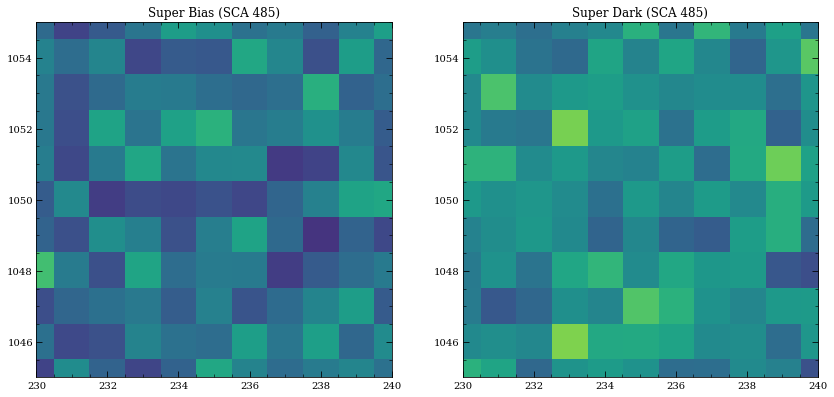

In [43]:
fig, axes = plt.subplots(1,2,figsize=(14,8))

titles = ['Super Bias (SCA {})'.format(scaid), 'Super Dark (SCA {})'.format(scaid)]
for i, im in enumerate([super_bias, super_dark]):

    mn = np.median(im)
    std = robust.medabsdev(im)

    vmin = mn - 3*std
    vmax = mn + 3*std
    ax = axes[i]
    ax.imshow(im, vmin=vmin, vmax=vmax)
    ax.set_title(titles[i])
    
    ax.set_xlim([230,240])
    ax.set_ylim([1045,1055])

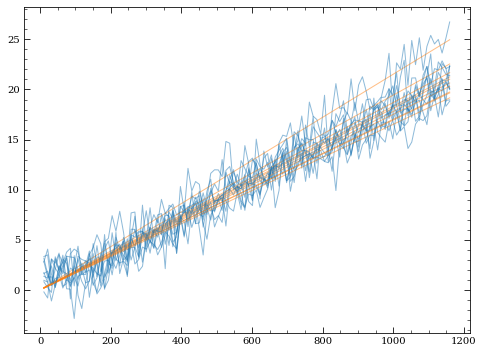

In [74]:
xvals = np.random.randint(5,2000, 10)
yvals = np.random.randint(5,2000, 10)

for i in range(len(xvals)):
    
    pix = data2[:,int(yvals[i]),int(xvals[i])]
#     pix = pix - np.median(pix)
    cf = jl_poly_fit(tarr,pix, deg=1)

    plt.plot(tarr, pix, color='C0', lw=1, alpha=0.5)
    plt.plot(tarr, jl_poly(tarr,cf), color='C1', lw=1, alpha=0.5)

In [90]:
cfarr = jl_poly_fit(tarr[:15], data2[:15,:,:], deg=1)

In [94]:
data2 -= cfarr[0]

In [95]:


# Get median of all pixels at each time step
ramp_avg = np.median(data2.reshape([nz,-1]), axis=1)
# Remove offset
cf = jl_poly_fit(tarr, ramp_avg)
# ramp_avg -= cf[0]

# del data2

1166.4249533983634 0.01872237275437635 0.01900762935236517


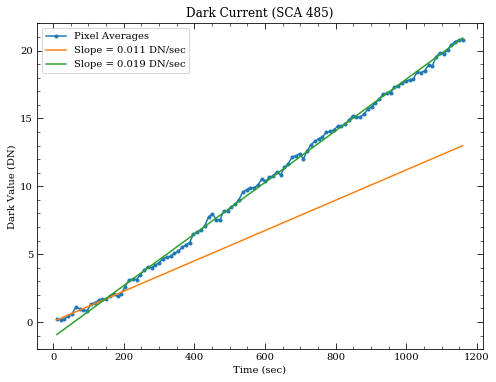

In [96]:

# print(np.median(super_bias0), np.median(super_dark2))

# Check linearity over flux range
plt.plot(tarr, ramp_avg, marker='.', label='Pixel Averages')

ind = tarr<200
cf = jl_poly_fit(tarr[ind], ramp_avg[ind], deg=1)
plt.plot(tarr, jl_poly(tarr,cf), label='Slope = {:.3f} DN/sec'.format(cf[1]))

ind = tarr>200
cf = jl_poly_fit(tarr[ind], ramp_avg[ind], deg=1)
plt.plot(tarr, jl_poly(tarr,cf), label='Slope = {:.3f} DN/sec'.format(cf[1]))


plt.xlabel('Time (sec)')
plt.ylabel('Dark Value (DN)')
plt.title('Dark Current (SCA {})'.format(scaid))
plt.legend()
# plt.plot(tarr, ramp_avg2, marker='.', ls='none', color='C1')
# bias, slope2 = jl_poly_fit(tarr, ramp_avg2)
# plt.plot(tarr, tarr*slope2, color='C1')

print(np.median(super_bias), np.median(super_dark), cf[1])

1166.4249533983634 0.01872237275437635 0.019006404623438004


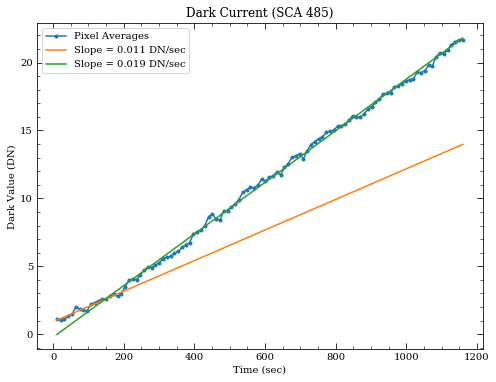

In [82]:

# print(np.median(super_bias0), np.median(super_dark2))

# Check linearity over flux range
plt.plot(tarr, ramp_avg, marker='.', label='Pixel Averages')

ind = tarr<200
cf = jl_poly_fit(tarr[ind], ramp_avg[ind], deg=1)
plt.plot(tarr, jl_poly(tarr,cf), label='Slope = {:.3f} DN/sec'.format(cf[1]))

ind = tarr>200
cf = jl_poly_fit(tarr[ind], ramp_avg[ind], deg=1)
plt.plot(tarr, jl_poly(tarr,cf), label='Slope = {:.3f} DN/sec'.format(cf[1]))


plt.xlabel('Time (sec)')
plt.ylabel('Dark Value (DN)')
plt.title('Dark Current (SCA {})'.format(scaid))
plt.legend()
# plt.plot(tarr, ramp_avg2, marker='.', ls='none', color='C1')
# bias, slope2 = jl_poly_fit(tarr, ramp_avg2)
# plt.plot(tarr, tarr*slope2, color='C1')

print(np.median(super_bias), np.median(super_dark), cf[1])

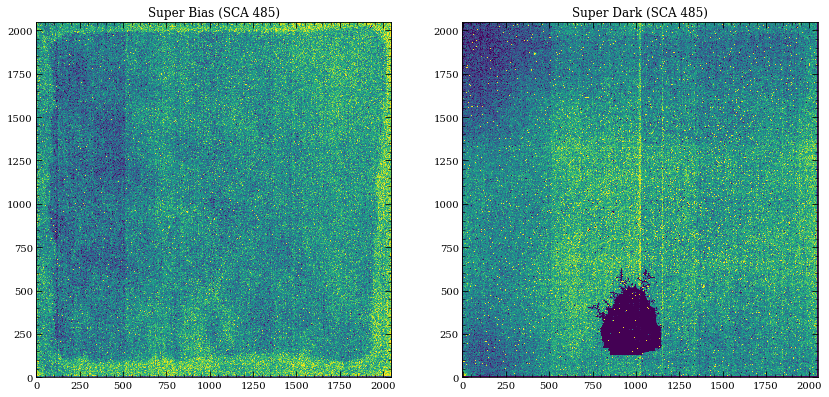

In [11]:
fig, axes = plt.subplots(1,2,figsize=(14,8))

titles = ['Super Bias (SCA {})'.format(scaid), 'Super Dark (SCA {})'.format(scaid)]
for i, im in enumerate([super_bias, super_dark]):

    mn = np.median(im)
    std = robust.medabsdev(im)

    vmin = mn - 3*std
    vmax = mn + 3*std
    ax = axes[i]
    ax.imshow(im, vmin=vmin, vmax=vmax)
    ax.set_title(titles[i])

In [12]:
# Histogram of Dark Slope
im = super_dark
#im = dark_all[0]
binsize = 0.0001
bins = np.arange(im.min(), im.max() + binsize, binsize)
igroups, vgroups, center_vals = nrc_utils.hist_indices(im, bins=bins, return_more=True)

# Choose only those pixels at the peak binsize
nvals = np.array([len(ig) for ig in igroups])
ind_nvals_max = np.where(nvals==nvals.max())[0][0]
ig_good = igroups[ind_nvals_max]

Dark Current = 0.0188 DN/sec


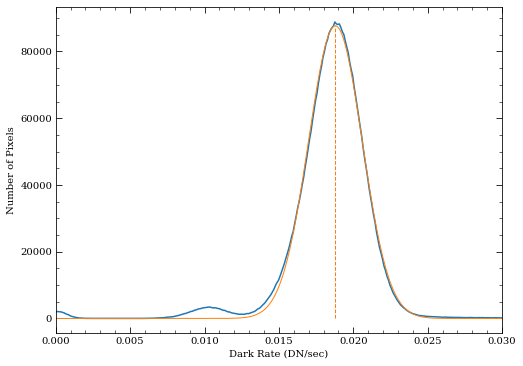

In [13]:
bg_max_dn = center_vals[ind_nvals_max]
#bg_max_e = bg_max_dn * gain
bg_max_npix = nvals[ind_nvals_max]

from astropy.modeling import models, fitting
mn_init, std_init = np.median(im), robust.std(im)
g_init = models.Gaussian1D(amplitude=nvals.max(), mean=mn_init, stddev=std_init)

fit_g = fitting.LevMarLSQFitter()
x, y = center_vals, nvals
ind_fit = (x>mn_init-10*std_init) & (x<mn_init+10*std_init)
g_res = fit_g(g_init, x[ind_fit], y[ind_fit])

bg_max_dn = g_res.mean.value
bg_max_npix = g_res.amplitude.value

plt.plot(center_vals, nvals)
plt.plot(2*[bg_max_dn], [0,bg_max_npix], ls='--', lw=1, color='C1')
plt.plot(x, g_res(x), label='Gaussian', lw=1, color='C1')
plt.xlabel('Dark Rate (DN/sec)')
plt.ylabel('Number of Pixels')

plt.xlim([0,0.03])

print('Dark Current = {:.4f} DN/sec'.format(bg_max_dn))

# IPC

In [14]:
# Get IPC & PPC values
# Subtract a blurred dark image to remove local variations
imdark = super_dark.copy()
imdark -= ndimage.median_filter(imdark, 7)

In [15]:
k_ipc, k_ppc = get_ipc_kernel(imdark, tarr.max(), bg_remove=False, calc_ppc=True)
print(k_ipc)
print(k_ppc)

[[3.84134703e-04 5.96783176e-03 3.84134703e-04]
 [5.96783176e-03 9.76128673e-01 5.96783176e-03]
 [3.84134703e-04 5.96783176e-03 3.84134703e-04]]
[[0.        0.        0.       ]
 [0.        0.9987649 0.0012351]
 [0.        0.        0.       ]]


In [16]:
# Flux-dependent values
vals1 = np.arange(5000,21000,1000)
vals2 = vals1+1000

vals = []
alpha_arr = []
ppc_arr = []
for v1 in vals1:
    k1, k2 = get_ipc_kernel(imdark, tarr.max(), boxsize=5, bg_remove=False, hotcut=[v1,v1+1000], calc_ppc=True)
    
    if k1 is not None:
        vals.append(v1+500)
        alpha_arr.append(k1[0,1])
        ppc_arr.append(k2[1,2])
        
vals = np.array(vals)
alpha_arr = np.array(alpha_arr)
ppc_arr = np.array(ppc_arr)

IPC = 0.597% +/- 0.018%
PPC = 0.124% +/- 0.010%


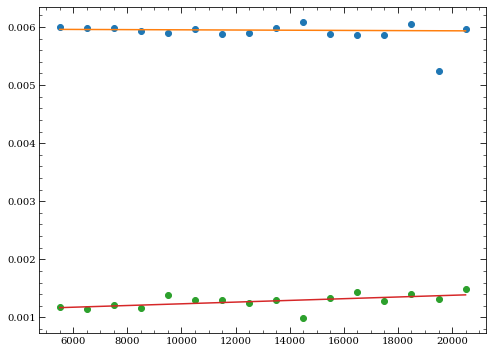

In [17]:
plt.plot(vals, alpha_arr, marker='o', ls='none')
cf1 = jl_poly_fit(vals, alpha_arr, robust_fit=True)
plt.plot(vals, jl_poly(vals, cf1))

plt.plot(vals, ppc_arr, marker='o', ls='none')
cf2 = jl_poly_fit(vals, ppc_arr, robust_fit=True)
plt.plot(vals, jl_poly(vals, cf2))

alpha = k_ipc[0,1]
_alpha = np.std(alpha_arr - jl_poly(vals, cf1))

ppc = k_ppc[1,2]
_ppc = np.std(ppc_arr - jl_poly(vals, cf2))


print('IPC = {:.3f}% +/- {:.3f}%'.format(alpha*100, _alpha*100))
print('PPC = {:.3f}% +/- {:.3f}%'.format(ppc*100, _ppc*100))

In [18]:
super_dark_deconv = ipc_deconvolve(super_dark, k_ipc)
super_bias_deconv = ipc_deconvolve(super_bias, k_ipc)

super_dark_deconv = ppc_deconvolve(super_dark_deconv, k_ppc)
super_bias_deconv = ppc_deconvolve(super_bias_deconv, k_ppc)

TypeError: 'float' object cannot be interpreted as an integer

In [18]:
nchans=nchan
same_scan_direction = reverse_scan_direction = False
for im in [super_dark_deconv, super_bias_deconv]:
    # Image cube shape
    sh = im.shape
    ndim = len(sh)
    if ndim==2:
        ny, nx = sh
        nz = 1
    else:
        nz, ny, nx = sh
    im = im.reshape([nz,ny,nchan,-1])

    for ch in np.arange(nchan):
        sub = im[:,:,ch,:]
        if same_scan_direction:
            flip = True if reverse_scan_direction else False
        elif np.mod(ch,2)==0:
            flip = True if reverse_scan_direction else False
        else:
            flip = False if reverse_scan_direction else True

        if flip: 
            sub = sub[:,:,::-1]

        sub = ipc_deconvolve(sub, k_ppc, kfft=kfft)
        if flip: 
            sub = sub[:,:,::-1]
        im[:,:,ch,:] = sub

    im = im.reshape(sh)

In [19]:
# Get IPC values
# Subtract a blurred dark image to remove local variations
imdark = super_dark_deconv.copy()
imdark -= ndimage.median_filter(imdark, 7)

k1, k2 = get_ipc_kernel(imdark, tarr.max(), bg_remove=False, calc_ppc=True)
print(k1)
print(k2)

[[2.80228587e-05 7.47127211e-05 2.80228587e-05]
 [7.47127211e-05 9.99701149e-01 7.47127211e-05]
 [2.80228587e-05 7.47127211e-05 2.80228587e-05]]
[[0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 9.99917319e-01 8.26806276e-05]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00]]


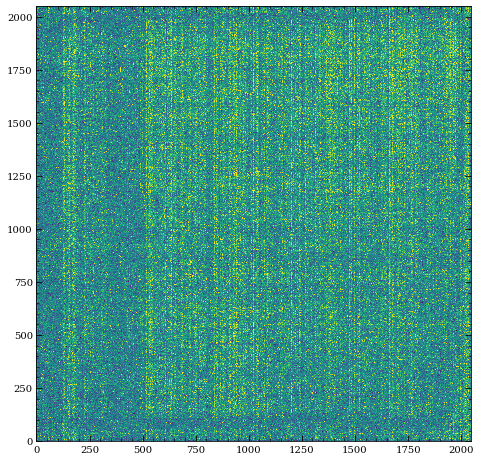

In [67]:
fig, ax = plt.subplots(1,1,figsize=(8,8))

im = _super_bias
mn = np.median(im)
std = robust.medabsdev(im)

vmin = mn - 3*std
vmax = mn + 3*std
ax.imshow(im, vmin=vmin, vmax=vmax)

In [41]:
diff = super_bias0 - super_bias

(-1, 1)

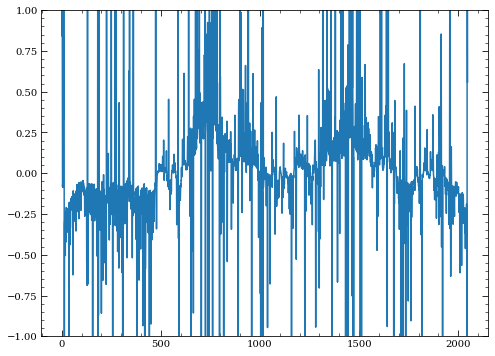

In [62]:
# plt.plot(diff[:,1020])
plt.plot(diff[:,1020] / super_bias[:,1020])
plt.ylim([-1,1])
# plt.plot(super_bias0[:,1020])